In [193]:
import pandas as pd

In [194]:
df = pd.read_csv('/content/data.csv')

In [195]:
df.head()

,title,description,url,label
0,Машинное обучение,Что такое машинное обучение и каким оно бывает...,https://education.yandex.ru/handbook/ml/articl...,Машинное обучение
1,"Машинное обучение: что это, для чего нужно, ос...",Подробный гайд о машинном обучении. Краткая ис...,https://practicum.yandex.ru/blog/chto-takoe-ma...,Машинное обучение
2,"Машинное обучение: суть, принципы, задачи",Машинное обучение — это способ автоматического...,https://gb.ru/blog/mashinoe-obuchenie/,Машинное обучение
3,Введение в машинное обучение / Хабр,1.1 Введение Благодаря машинному обучению прог...,https://habr.com/ru/articles/448892/,Машинное обучение
4,Основы машинного обучения (machine learning) /...,Что такое машинное обучение (machine learning)...,https://skillbox.ru/media/code/kak-ustroeno-ma...,Машинное обучение


In [196]:
#!pip install pandas nltk spacy
#!python -m spacy download ru_core_news_sm
#!pip install keras

In [197]:
import string
import nltk
from nltk.corpus import stopwords
import spacy
import re

In [198]:
nlp = spacy.load('ru_core_news_sm')
nltk.download('stopwords')
stop_words = list(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [199]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    doc = nlp(' '.join(words))
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

In [200]:
df['description'] = df.apply(lambda row: row['title'] if pd.isna(row['description']) or row['description'].strip() == '' else row['description'], axis=1)

In [201]:
df['title_clean'] = df['title'].apply(preprocess_text)
df['description_clean'] = df['description'].apply(preprocess_text)

print(df[['title', 'title_clean', 'description', 'description_clean']].head())

                                               title  \
0                                  Машинное обучение   
1  Машинное обучение: что это, для чего нужно, ос...   
2          Машинное обучение: суть, принципы, задачи   
3                Введение в машинное обучение / Хабр   
4  Основы машинного обучения (machine learning) /...   

                                         title_clean  \
0                                  машинный обучение   
1  машинный обучение это нужный основа принцип ти...   
2              машинный обучение суть принцип задача   
3                    введение машинный обучение хабр   
4                           основа машинный обучение   

                                         description  \
0  Что такое машинное обучение и каким оно бывает...   
1  Подробный гайд о машинном обучении. Краткая ис...   
2  Машинное обучение — это способ автоматического...   
3  1.1 Введение Благодаря машинному обучению прог...   
4  Что такое машинное обучение (machine learni

In [202]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [203]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [204]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['title_clean'] + " " + df['description_clean'])

In [205]:
title_seq = tokenizer.texts_to_sequences(df['title_clean'])
description_seq = tokenizer.texts_to_sequences(df['description_clean'])

In [206]:
title_pad = pad_sequences(title_seq, padding='post', maxlen=100)
description_pad = pad_sequences(description_seq, padding='post', maxlen=100)

In [207]:
import numpy as np

In [208]:
X = np.concatenate([title_pad, description_pad], axis=1)

y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=len(df['label'].unique()))
y_test = to_categorical(y_test, num_classes=len(df['label'].unique()))

In [210]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
max_len = 100

In [211]:
from tensorflow.keras.models import Sequential

In [212]:
print("Размер X_train:", X_train.shape)
print("Размер y_train:", y_train.shape)
print("Размер X_test:", X_test.shape)
print("Размер y_test:", y_test.shape)

Размер X_train: (204, 200)
Размер y_train: (204, 18)
Размер X_test: (51, 200)
Размер y_test: (51, 18)


In [213]:
from tensorflow.keras.optimizers import Adam

In [214]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=200))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(18, activation='softmax'))


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [215]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 909ms/step - accuracy: 0.0854 - loss: 2.8894 - val_accuracy: 0.1961 - val_loss: 2.8638
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - accuracy: 0.1004 - loss: 2.8725 - val_accuracy: 0.1961 - val_loss: 2.8398
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - accuracy: 0.0968 - loss: 2.8504 - val_accuracy: 0.1961 - val_loss: 2.7911
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 513ms/step - accuracy: 0.1150 - loss: 2.8192 - val_accuracy: 0.1961 - val_loss: 2.7922
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.1046 - loss: 2.8241 - val_accuracy: 0.1961 - val_loss: 2.8227
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 938ms/step - accuracy: 0.0938 - loss: 2.8315 - val_accuracy: 0.1961 - val_loss: 2.7909
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - accuracy: 0.1114 - loss: 2.7944 - val_accuracy: 0.1961 - val_loss: 2.7651
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - accuracy: 0.1030 - loss: 2.7980 - val_accuracy: 0.1961 - val_loss:

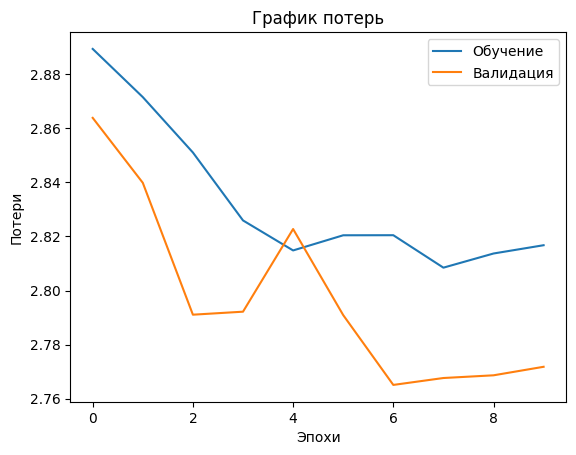

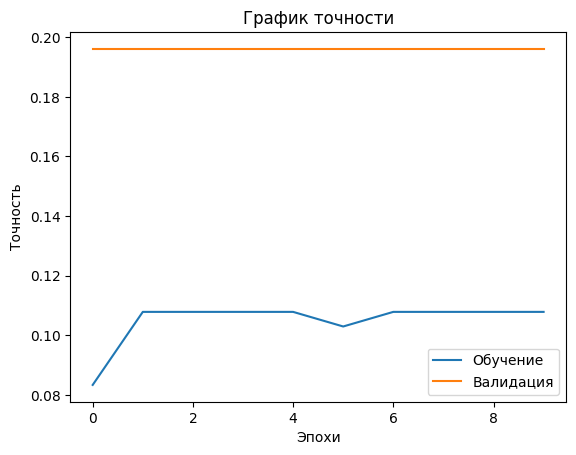

In [216]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('График потерь')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Обучение')
plt.plot(history.history['val_accuracy'], label='Валидация')
plt.title('График точности')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

In [217]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2036 - loss: 2.7671
